## some config

In [163]:
import os
import math
import random
import torch
# import fires
import copy
import multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler
# import deepspeed
from datetime import datetime
from typing import Optional
from pprint import pprint, pformat
from torch.utils.data import DataLoader, IterableDataset
from timm.utils import ModelEmaV3
from timm.models import load_checkpoint
from timm.utils.model import unwrap_model, get_state_dict
try:
    from torch.utils.tensorboard import SummaryWriter
except ModuleNotFoundError:
    from tensorboardX import SummaryWriter

import sys

# sys.path.insert(0, "..")
sys.path.insert(0, ".")

In [164]:
from src.data import (
    collator,
    vocab_builder,
    tokenizer,
    read_dataset,
    OdpsTableIterableDataset,
)
from src.models import (
    GraphGPTConfig,
    GraphGPTCausal,
    GraphGPT2Config,
    GraphGPT2Causal,
    GraphBertConfig,
    GraphBertForMaskedLM,
)
from src.utils import (
    conf_utils,
    loss_utils,
    loader_utils,
    tokenizer_utils,
    modules_utils,
    misc_utils,
    print_trainable_parameters,
    print_params,
    inspect_tokenization_results,
    set_up_shuffle_and_sampler,
    worker_init_fn_seed,
)

dict_models = {
    "graphgpt2": (GraphGPT2Causal, GraphGPT2Config),
    "graphgpt": (GraphGPTCausal, GraphGPTConfig),
    "graphbert": (GraphBertForMaskedLM, GraphBertConfig),
}

In [165]:
data_dir: str = "../data/OGB"
tables: str = ""
# deepspeed_config = "./examples/ds_config2_pt.json"
intermediate_size = 0
num_attention_heads = 0
hidden_size = 512
num_hidden_layers = 8
task_type='pretrain'
causal_attention = 1
lr=3e-4
model_type = 'graphgpt'
output_dir='./exp/models/pcqm4m-v2/test'
pretrain_cpt = '/datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1'
samples_per_saving=1000000

batch_size = 1024
stack_method = 'short'

pack_tokens = 0
max_position_embeddings = 1024

task_type='pretrain'
total_tokens=1e9
batch_size = 1024
warmup_tokens=1e8

In [166]:
use_tb_writer = False           # use tensorboard writer
use_ema = False # False # use exponential moving average to smooth model
use_deepspeed = False # True # use deepspeed for training, good to set scheduler
if (intermediate_size == 0) and (num_attention_heads == 0): # True
    (
        hidden_size,
        intermediate_size,
        num_attention_heads,
        num_hidden_layers,
    ) = modules_utils.set_up_model_architect(
        hidden_size=hidden_size, num_hidden_layers=num_hidden_layers # 768 24 related to model names intermediate_size = hidden_size * 4, num_attention_heads = hidden_size // 64
    )# 768 3072 12 24
causal_attention = 0 if task_type == "pretrain-mlm" else causal_attention
print('hidden_size:', hidden_size, 'intermediate_size:', intermediate_size, 'num_attention_heads:', num_attention_heads, 'num_hidden_layers:', num_hidden_layers, 'causal_attention:', causal_attention) # 768 3072 12 24 1


# #########################
# betas = (0.9, 0.95) # used in AdamW optimizer, important for config beta
# #########################
# # lr * 0.1 -> from llama2 pre-train settings
# min_lr = lr * 0.1 if use_deepspeed else 0    # used in scheduler, when not using deepspeed.
# #########################
gpu_name = torch.cuda.get_device_name()
GraphModel, GraphModelConfig = dict_models[model_type] # Not instantiate yet
print('gpu_name:', gpu_name, 'GraphModel:', GraphModel, 'GraphModelConfig:', GraphModelConfig) 

if os.path.exists(os.path.join(output_dir, "log.csv")):
    print(
        f"log file {os.path.join(output_dir, 'log.csv')} exists, resume training from {output_dir} instead of initializing from pre-train ckp {pretrain_cpt}!"
    )
    pretrain_cpt = output_dir


# # 0. init distributed train and get gpu/device info
# dist.init_process_group(backend="nccl", init_method="env://")  # for distributed training
# dist.barrier() # for sync training
# world_size = dist.get_world_size() # 1 # number of GPUs
# rank = dist.get_rank() # 0 # current GPU index
# local_rank = os.environ.get("LOCAL_RANK") # 0 # current GPU index local to the node
# print(f"\nworld size: {world_size}, rank: {rank}, local rank: {local_rank}") # 1 0 0
# rnd_seed = torch.random.initial_seed() - rank
# random.seed(rnd_seed)
# print(f"seed random with {rnd_seed}") # 1234
# steps_per_saving = samples_per_saving // (world_size * batch_size) # 1000000 // (1 * 1024) = 976
# print(f"\nsteps_per_saving: {steps_per_saving}") # 976
# params = print_params(**locals())

hidden_size: 512 intermediate_size: 2048 num_attention_heads: 8 num_hidden_layers: 8 causal_attention: 1
gpu_name: NVIDIA RTX A6000 GraphModel: <class 'src.models.graphgpt.modeling_graphgpt.GraphGPTCausal'> GraphModelConfig: <class 'src.models.graphgpt.configuration_graphgpt.GraphGPTConfig'>


## load data

In [167]:
# tokenizer config loading
import json

# Load the JSON file
file_path = "./zhang_test/tokenizer_config.json"
with open(file_path, "r") as json_file:
    tokenizer_config = json.load(json_file)

# Print the loaded data
# pprint(tokenizer_config)

In [168]:
# 1.1 read configuration
assert "pretrain" in tokenizer_config["task_type"]
assert (
    tokenizer_config["semantics"]["attr_assignment"]   # first
    in tokenizer_utils.ATTR_ASSIGNMENT_TYPES   # ATTR_ASSIGNMENT_TYPES = {"first", "last", "random", "all", "mix"}
)
# pprint(tokenizer_config)
if tokenizer_config["tokenizer_class"] == "StackedGSTTokenizer":
    attr_dim = (
        tokenizer_config["semantics"]["edge"]["dim"] # 3
        + tokenizer_config["semantics"]["node"]["dim"] # 9
    ) # 12
    assert stack_method in ("short", "long", None), f"stack_method: {stack_method}" # short
    if tokenizer_config["structure"]["edge"]["remove_edge_type_token"]: # True
        stacked_feat = 1 + attr_dim
    else:
        stacked_feat = 2 + attr_dim
    next_n_token = stacked_feat
else:
    stacked_feat = 1
    next_n_token = 1 # maybe how many pack of tokens to predict
embed_dim = tokenizer_config["semantics"]["node"].get(
    "embed_dim", 0
) + tokenizer_config["semantics"]["edge"].get("embed_dim", 0) # 0
print(
    f"stacked_feat: {stacked_feat}, next_n_token: {next_n_token}, embed_dim: {embed_dim}" # 13 13 0
)

stacked_feat: 13, next_n_token: 13, embed_dim: 0


## build vocabulary

In [169]:
add_eos = False
rank = 0
stack_method = "short"
# 1.3 build vocab and then init tokenizer from the tokenization config
tokenizer_cls = getattr(tokenizer, tokenizer_config["tokenizer_class"]) # StackGSTTokenizer, custom defined
gtokenizer = tokenizer_cls(
    tokenizer_config, add_eos=add_eos, stack_method=stack_method # instantiate
)

[2025-05-16 16:37:43.563652] Loading vocab from ./data/OGB/pcqm4m-v2/vocab512_stacked ...
[2025-05-16 16:37:43.566104]
{   '0': 22,
    '1': 23,
    '10': 32,
    '100': 122,
    '101': 123,
    '102': 124,
    '103': 125,
    '104': 126,
    '105': 127,
    '106': 128,
    '107': 129,
    '108': 130,
    '109': 131,
    '11': 33,
    '110': 132,
    '111': 133,
    '112': 134,
    '113': 135,
    '114': 136,
    '115': 137,
    '116': 138,
    '117': 139,
    '118': 140,
    '119': 141,
    '12': 34,
    '120': 142,
    '121': 143,
    '122': 144,
    '123': 145,
    '124': 146,
    '125': 147,
    '126': 148,
    '127': 149,
    '128': 150,
    '129': 151,
    '13': 35,
    '130': 152,
    '131': 153,
    '132': 154,
    '133': 155,
    '134': 156,
    '135': 157,
    '136': 158,
    '137': 159,
    '138': 160,
    '139': 161,
    '14': 36,
    '140': 162,
    '141': 163,
    '142': 164,
    '143': 165,
    '144': 166,
    '145': 167,
    '146': 168,
    '147': 169,
    '148': 170,
 

In [170]:
print(gtokenizer)

## set model

In [171]:
import pickle
with open("./zhang_test/model_config.pkl", "rb") as file:  # "rb" mode for reading binary
    config = pickle.load(file)
# print(config)

In [172]:
# use_deepspeed = True

# # 2.2 create model
# if use_deepspeed:
#     deepspeed.init_distributed(
#         dist_backend="nccl", rank=rank, world_size=world_size
#     )

In [173]:
model = GraphModel(config)


# model.gradient_checkpointing_enable()
# silence the warnings. Please re-enable for inference!
model.config.use_cache = False
print_trainable_parameters(model) # 235368960

NOT Applying dropout in backbone transformer
Next-token-prediction changed to next/masked-13-tokens-prediction!
trainable params: 37751808 || all params: 37751808 || trainable%: 100.0


In [174]:

# 2.21 load from ckp IF provided existing ckp and NOT resume from the ckp
ckp, _ = misc_utils.get_latest_ckp(pretrain_cpt)
print(f"Loading pretrained weights from ckp {ckp}")
try:
    # fn_model = os.path.join(ckp, "../model_ema_best.pt")
    # if not os.path.isfile(fn_model):
    fn_model = os.path.join(ckp, "model.pt")
    stat_dict = torch.load(fn_model)
    stat_dict = {
        (k[7:] if k.startswith("module.") else k): v for k, v in stat_dict.items()
    }
    print(f"[{datetime.now()}] load ckp using torch API from:\n{fn_model}")
except Exception as inst:
    # print(type(inst))
    # print(inst.args)
    print("inar: ", inst)
    from deepspeed.utils.zero_to_fp32 import (
        get_fp32_state_dict_from_zero_checkpoint,
    )
    stat_dict = get_fp32_state_dict_from_zero_checkpoint(ckp)
    print(
        f"[{datetime.now()}] load ckp using DeepSpeed API `get_fp32_state_dict_from_zero_checkpoint`"
    )

for key in list(stat_dict.keys()):
    if ("score" in key) and skip_keys:
        stat_dict.pop(key)
        print(f"pop key {key} in stat_dict!")
missing_keys, unexpected_keys = model.load_state_dict(stat_dict, strict=True)
print(
    f"[{datetime.now()}] init model params using pytorch `load_state_dict`\n"
    f"missing keys: {missing_keys}\n"
    f"unexpected_keys: {unexpected_keys}\n"
    f"After loading weights from ckp:\n{model.config}\nmodel-type: {model.dtype}\n\n{model}"
)

Loading pretrained weights from ckp /datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1/epoch_51
inar:  [Errno 2] No such file or directory: '/datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1/epoch_51/model.pt'
Processing zero checkpoint '/datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1/epoch_51/global_step48830'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.15.1
Reconstructed fp32 state dict with 77 params 37751808 elements
[2025-05-16 16:37:45.130730] load ckp using DeepSpeed API `get_fp32_stat

## test

In [175]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"device: {device}")
print(model.device)

device: cuda
cuda:0


In [176]:
print(embed_dim)

0


In [177]:
# 1.2 get graph dataset
train_dataset, valid_dataset, test_dataset, raw_dataset = read_dataset(
    name=tokenizer_config["dataset"],   # PCQM4Mv2
    # for local data file reading
    data_dir=data_dir,   # './data/OGB'
    sampling_config=tokenizer_config["sampling"],    # None
    # for odps data reading
    table=tables,   # ""
    edge_dim=tokenizer_config["semantics"]["edge"]["dim"],    # 3
    node_dim=tokenizer_config["semantics"]["node"]["dim"],    # 9
    mode="train",
    # general
    # pretrain_mode=True,
    return_valid_test=True,
    ensemble_datasets=tokenizer_config.get("ensemble_datasets", []),    # []
)
reset_samples_per_epoch = (   # what is this  # None for PCQM4Mv2
    test_dataset.reset_samples_per_epoch
    if hasattr(test_dataset, "reset_samples_per_epoch")
    else False
)
if isinstance(test_dataset, IterableDataset):
    print(next(iter(test_dataset))) 
else: # True
    idx = test_dataset.sampler[0] # (0, Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1, 1], num_nodes=18, idx=0, idx_of_ds=0))
    print(test_dataset[idx])


Loading dataset PCQM4Mv2 ...

dataset._data -> Data(edge_index=[2, 109093626], edge_attr=[109093626, 3], x=[52970652, 9], y=[3746620])

Raw indices: 3378606, Removed indices: 0, New indices: 3378606

Raw indices: 73545, Removed indices: 0, New indices: 73545
Using all valid data as valid: 73545, and last half of valid data as test: 36773!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!

[2025-05-16 16:38:06.442730] NOT RESET samples of GraphsMapDataset of 3378606 graphs for epoch None!
idx_tuple: None
[Warning] permu

In [178]:
print(test_dataset)
print('length of test dataset:', len(test_dataset), 'length of train dataset:', len(train_dataset), 'length of valid dataset:', len(valid_dataset))
print(test_dataset[1])
print(test_dataset[2])
print("#" * 100)
print("example")
print("edge_index: ", test_dataset[1][1].edge_index)
print("edge_attr: ", test_dataset[1][1].edge_attr)
print("x: ", test_dataset[1][1].x)
print("y: ", test_dataset[1][1].y) 

length of test dataset: 36773 length of train dataset: 3378606 length of valid dataset: 73545
(1, Data(edge_index=[2, 34], edge_attr=[34, 3], x=[17, 9], y=[1], num_nodes=17, idx=1, idx_of_ds=0))
(2, Data(edge_index=[2, 32], edge_attr=[32, 3], x=[16, 9], y=[1], num_nodes=16, idx=2, idx_of_ds=0))
####################################################################################################
example
edge_index:  tensor([[12, 13, 13,  2,  2,  8,  8, 16, 16,  0,  0,  6, 16, 14, 14,  4,  4,  3,
          3, 10, 10,  5,  5, 15, 15,  1,  1,  7,  1, 11, 15,  9,  3,  2],
        [13, 12,  2, 13,  8,  2, 16,  8,  0, 16,  6,  0, 14, 16,  4, 14,  3,  4,
         10,  3,  5, 10, 15,  5,  1, 15,  7,  1, 11,  1,  9, 15,  2,  3]])
edge_attr:  tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [3, 

In [179]:
graph_test = test_dataset[2][1]
from src.utils.my_utiles import graph2smiles
smiles = graph2smiles(graph_test.edge_index, graph_test.edge_attr, graph_test.x)
print(smiles)

C=CCN(C=Cc1ccccc1C)C(C)=O


In [180]:
from src.utils.my_utiles import smiles2graph
smiles = "CCO"
graph = smiles2graph("CC(=O)OC1=CC=CC=C1C(=O)O")
print(graph.keys())
print(graph['edge_index'].shape)
print(graph['edge_attr'].shape)
print(graph['x'].shape)
print(graph['num_nodes'])


dict_keys(['edge_index', 'edge_attr', 'x', 'num_nodes'])
(2, 26)
(26, 3)
(13, 9)
13


In [181]:
from src.utils.my_utiles import graph_to_torch_geometric
graph = graph_to_torch_geometric(graph)
print(graph['edge_index'].shape)
print(graph['edge_attr'].shape)
print(graph['x'].shape)
print(graph['num_nodes'])

torch.Size([2, 26])
torch.Size([26, 3])
torch.Size([13, 9])
13


In [182]:
from src.utils.my_utiles import graph2smiles
smiles = graph2smiles(graph.edge_index, graph.edge_attr, graph.x)
print(smiles)

CC(=O)Oc1ccccc1C(=O)O


In [183]:
example_graph = graph_test
from src.utils.my_utiles import graph2token2input
import numpy as np
token, label, embed, inputs = graph2token2input(example_graph, gtokenizer)

print(
    f"\nTokens:\n{pformat(token)}\nLabels:\n{pformat(label)}\nembed:{np.array(embed)}\n"
)

print(f"Inputs for model:\n{pformat(inputs)}\n")

Inspecting tokenization results!
Tokenize graph:
Data(edge_index=[2, 32], edge_attr=[32, 3], x=[16, 9], y=[1], num_nodes=16, idx=2, idx_of_ds=0)
[Warning] Set eos_idx to 100000000 for task pretrain!

Tokens:
[['165',
  'molecule#node#0#6',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#0',
  'molecule#node#8#0',
  'molecule#edge#0',
  'molecule#edge#1',
  'molecule#edge#2'],
 ['166',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#0',
  'molecule#node#8#0',
  'molecule#edge#0#0',
  'molecule#edge#1#0',
  'molecule#edge#2#1'],
 ['167',
  'molecule#node#0#7',
  'molecule#node#1#0',
  'molecule#node#2#1',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#0',
  'molecule#node#8#0',
  'molecul

In [184]:
print(inputs.keys())

dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])


In [185]:
from src.utils.my_utiles import convert_to_tensors

tensor_inputs = convert_to_tensors(inputs)
print(tensor_inputs.keys())

print("input_ids:", tensor_inputs["input_ids"].shape)
print("position_ids:", tensor_inputs["position_ids"].shape)
print("labels:", tensor_inputs["labels"].shape)
print("attention_mask:", tensor_inputs["attention_mask"].shape)
print("embed:", tensor_inputs["embed"].shape)


dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])
input_ids: torch.Size([1, 24, 13])
position_ids: torch.Size([1, 24])
labels: torch.Size([1, 24, 13])
attention_mask: torch.Size([1, 24])
embed: torch.Size([1, 24, 0])


In [186]:
print(tensor_inputs["input_ids"])
print(tensor_inputs["labels"])

tensor([[[187, 641, 685, 695, 709, 714, 724, 731, 736, 738, 740, 741, 742],
         [188, 630, 685, 695, 709, 714, 724, 731, 736, 738, 743, 748, 755],
         [189, 652, 685, 691, 709, 714, 724, 731, 736, 738, 744, 748, 755],
         [188, 630, 685, 695, 709, 714, 724, 731, 736, 738, 744, 748, 755],
         [190, 630, 685, 696, 709, 717, 724, 732, 736, 738, 743, 748, 754],
         [188, 630, 685, 695, 709, 714, 724, 731, 736, 738, 743, 748, 754],
         [187, 641, 685, 695, 709, 714, 724, 731, 736, 738, 743, 748, 755],
         [191, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [192, 630, 685, 695, 709, 715, 724, 731, 736, 738, 743, 748, 754],
         [193, 630, 685, 695, 709, 716, 724, 731, 736, 738, 744, 748, 754],
         [192, 630, 685, 695, 709, 715, 724, 731, 736, 738, 744, 748, 754],
         [191, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [187, 641, 685, 695, 709, 714, 724, 731, 736, 738, 743, 748, 754],
         [19

In [187]:
print("input_ids:", tensor_inputs["input_ids"].shape)
print("position_ids:", tensor_inputs["position_ids"].shape)
print("labels:", tensor_inputs["labels"].shape)
print("attention_mask:", tensor_inputs["attention_mask"].shape)
print("embed:", tensor_inputs["embed"].shape)


input_ids: torch.Size([1, 24, 13])
position_ids: torch.Size([1, 24])
labels: torch.Size([1, 24, 13])
attention_mask: torch.Size([1, 24])
embed: torch.Size([1, 24, 0])


In [188]:
tensor_inputs["embed"]

tensor([], size=(1, 24, 0), dtype=torch.float64)

In [189]:
from src.utils.my_utiles import graph2token2input_generation
# smiles = "CCO" # "CC(=O)OC1=CC=CC=C1C(=O)O"\
random_index = np.random.randint(0, len(test_dataset))  # Upper bound is exclusive
print(random_index)
random_index = 0
graph = test_dataset[random_index][1]
# graph = graph_to_torch_geometric(graph)
smiles2 = graph2smiles(graph.edge_index, graph.edge_attr, graph.x)
example_graph = graph
print(smiles2)

num_input, max_length = 5, 40
token, label, embed, inputs = graph2token2input(graph, gtokenizer)
print('token', np.array(token).shape)
print('label', np.array(label).shape)
print('embed', np.array(embed).shape)
print(inputs.keys())
print('input_ids', np.array(inputs["input_ids"]).shape)
print('position_ids', np.array(inputs["position_ids"]).shape)
print('labels', np.array(inputs["labels"]).shape)
print('attention_mask', np.array(inputs["attention_mask"]).shape)
# print('embed', np.array(inputs["embed"]).shape)
print(inputs["attention_mask"])
tensor_inputs = convert_to_tensors(inputs)

6440
Cc1ccc(C2Cc3cnccc3NC2=O)cc1
Inspecting tokenization results!
Tokenize graph:
Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1], num_nodes=18, idx=0, idx_of_ds=0)
token (25, 13)
label (25, 13)
embed (25, 0)
dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])
input_ids (25, 13)
position_ids (25,)
labels (25, 13)
attention_mask (25,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [190]:
model.eval()
data = tensor_inputs
input_ids = data["input_ids"].to(device)
# print(input_ids)
attention_mask = data["attention_mask"].to(device)
labels = data["labels"].to(device)
inputs_raw_embeds = None
if embed_dim > 0: # in tokenizer config
    inputs_raw_embeds = data["embed"].to(device)
print(inputs_raw_embeds)
output = model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels,
    inputs_raw_embeds=inputs_raw_embeds,
)  # Perform a single forward pass.
print(output)


None


CausalLMOutputWithPast(loss=tensor(0.1313, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.5467, -0.6913, -0.7591,  ..., -0.9735,  0.7295,  0.1214],
        [-8.3267, -8.2283, -8.2161,  ..., -8.1347, -3.2014, -3.1003],
        [-4.2555, -4.6625, -4.4946,  ..., -4.6253, -0.9444, -1.0318],
        ...,
        [-0.1751,  0.1436, -0.4383,  ..., -0.6150,  1.7899,  0.0686],
        [ 2.2697,  2.6892,  2.9154,  ...,  2.7431,  3.2211,  0.5504],
        [-1.2200, -1.3780, -0.9202,  ..., -1.5514,  4.1868,  3.4425]],
       device='cuda:0', grad_fn=<ViewBackward0>), past_key_values=None, hidden_states=None, attentions=None)


In [191]:
# print("labels:", tensor_inputs["labels"].shape)
# print("output:", output.keys())
# print("output:", output["logits"].shape)

In [192]:
# predicted_labels = torch.argmax(output["logits"], dim=-1) 
# reshaped_labels = predicted_labels.view(*tensor_inputs["labels"].shape)
# print("labels:", tensor_inputs["labels"])
# print("predicted_labels:", reshaped_labels)

In [193]:
# # File path to your vocabulary file
# vocab_file_path = "/datalake/datastore1/yang/graph-gpt/data/OGB/pcqm4m-v2/vocab512_stacked"

# from src.utils.my_utiles import load_vocab

# vocab = load_vocab(vocab_file_path)

# from src.utils.my_utiles import convert_labels_to_tokens
# # Example usage
# # Assuming `reshaped_labels` contains the predicted label IDs of shape [1, 24, 13]
# tokens = convert_labels_to_tokens(reshaped_labels, vocab)

# # Optional: Reshape tokens back to the original structure for visualization
# tokens_reshaped = [
#     [tokens[i * 13 + j] for j in range(13)] for i in range(tensor_inputs["labels"].shape[1])
# ]

# print(reshaped_labels.shape)
# # Print tokens
# print(np.array(tokens_reshaped).shape)
# pprint(tokens_reshaped)


# test generation

In [194]:
from src.utils.my_utiles import graph2token2input_generation
# smiles = "CCO" # "CC(=O)OC1=CC=CC=C1C(=O)O"\
random_index = np.random.randint(0, len(test_dataset))  # Upper bound is exclusive
print(random_index)
random_index = 0
graph = test_dataset[random_index][1]
# graph = graph_to_torch_geometric(graph)
smiles2 = graph2smiles(graph.edge_index, graph.edge_attr, graph.x)
example_graph = graph
print(smiles2)

num_input, max_length = 5, 40
token, label, embed, inputs = graph2token2input_generation(graph, gtokenizer, num_input, max_length)
print('token', np.array(token).shape)
print('label', np.array(label).shape)
print('embed', np.array(embed).shape)
print(inputs.keys())
print('input_ids', np.array(inputs["input_ids"]).shape)
print('position_ids', np.array(inputs["position_ids"]).shape)
print('labels', np.array(inputs["labels"]).shape)
print('attention_mask', np.array(inputs["attention_mask"]).shape)
# print('embed', np.array(inputs["embed"]).shape)
print(inputs["attention_mask"])

2873
Cc1ccc(C2Cc3cnccc3NC2=O)cc1
Inspecting tokenization results!
Tokenize graph:
Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1], num_nodes=18, idx=0, idx_of_ds=0)
token (5, 13)
label (25, 13)
embed (5, 0)
dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])
input_ids (5, 13)
position_ids (5,)
labels (25, 13)
attention_mask (5,)
[1. 1. 1. 1. 1.]


In [195]:
# pprint(token)
# pprint(label)
# pprint(inputs["input_ids"])
# pprint(inputs["labels"])

In [196]:
tensor_inputs = convert_to_tensors(inputs)
# print(tensor_inputs)

In [197]:
model.device

device(type='cuda', index=0)

In [198]:
tensor_inputs.keys()

dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])

In [199]:
# model.eval()
# output_ids = model.generate(
#     input_ids=tensor_inputs["input_ids"].to(device) ,          # Input token IDs
#     attention_mask=tensor_inputs["attention_mask"].to(device),  # Pass the attention mask
#     position_ids=tensor_inputs["position_ids"].to(device),      # Pass the position IDs
#     max_length=20,                # Maximum generation length
#     do_sample=True,               # Enable sampling
#     temperature=0.7               # Temperature for randomness
# )

# test generation my defined

In [200]:
from src.utils.my_utiles import graph2token2input_generation
# smiles = "CCO" # "CC(=O)OC1=CC=CC=C1C(=O)O"\
random_index = np.random.randint(0, len(test_dataset))  # Upper bound is exclusive
print(random_index)
random_index = 0
graph = test_dataset[random_index][1]
# graph = graph_to_torch_geometric(graph)
smiles2 = graph2smiles(graph.edge_index, graph.edge_attr, graph.x)
example_graph = graph
print(smiles2)

num_input, max_length = 2, 40
token, label, embed, inputs = graph2token2input_generation(graph, gtokenizer, num_input, max_length)
print('token', np.array(token).shape)
print('label', np.array(label).shape)
print('embed', np.array(embed).shape)
print(inputs.keys())
print('input_ids', np.array(inputs["input_ids"]).shape)
print('position_ids', np.array(inputs["position_ids"]).shape)
print('labels', np.array(inputs["labels"]).shape)
print('attention_mask', np.array(inputs["attention_mask"]).shape)
# print('embed', np.array(inputs["embed"]).shape)
print(inputs["attention_mask"])

31740
Cc1ccc(C2Cc3cnccc3NC2=O)cc1
Inspecting tokenization results!
Tokenize graph:
Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1], num_nodes=18, idx=0, idx_of_ds=0)
token (2, 13)
label (25, 13)
embed (2, 0)
dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])
input_ids (2, 13)
position_ids (2,)
labels (25, 13)
attention_mask (2,)
[1. 1.]


In [201]:
tensor_inputs = convert_to_tensors(inputs)
# print(tensor_inputs)

In [202]:
tensor_inputs.keys()

dict_keys(['input_ids', 'position_ids', 'labels', 'attention_mask', 'embed'])

In [203]:
print("input_ids:", tensor_inputs["input_ids"].shape)
print("position_ids:", tensor_inputs["position_ids"].shape)
print("labels:", tensor_inputs["labels"].shape)
print("attention_mask:", tensor_inputs["attention_mask"].shape)
print("embed:", tensor_inputs["embed"].shape)

input_ids: torch.Size([1, 2, 13])
position_ids: torch.Size([1, 2])
labels: torch.Size([1, 25, 13])
attention_mask: torch.Size([1, 2])
embed: torch.Size([1, 2, 0])


In [204]:
model.eval()
generated = model.generate_packed(
    input_ids=tensor_inputs["input_ids"].to(device),
    attention_mask=tensor_inputs["attention_mask"].to(device),
    max_new_tokens = 30,
    temperature = 1,
    top_k = 50,
    eos_token_id = 19,
    pad_token_id = 0,
    entire_context = True,
)


In [205]:
generated

tensor([[[139, 630, 685, 695, 709, 715, 724, 731, 737, 739, 740, 741, 742],
         [140, 641, 685, 694, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [141, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [142, 652, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 755],
         [143, 630, 685, 696, 709, 716, 724, 732, 736, 739, 743, 748, 754],
         [144, 630, 685, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [145, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [146, 641, 685, 694, 709, 716, 724, 731, 736, 738, 743, 748, 754],
         [145, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [144, 630, 685, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [147, 630, 685, 696, 709, 716, 724, 732, 736, 739, 743, 748, 754],
         [142, 641, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 754],
         [141, 630, 685, 695, 709, 714, 724, 731, 737, 739, 743, 748, 754],
         [14

In [206]:
# non_zero_mask = (generated.sum(dim=-1) != 0)
# print(non_zero_mask.shape)
# generated = generated[non_zero_mask.any(dim=-1)]

In [207]:
generated

tensor([[[139, 630, 685, 695, 709, 715, 724, 731, 737, 739, 740, 741, 742],
         [140, 641, 685, 694, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [141, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [142, 652, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 755],
         [143, 630, 685, 696, 709, 716, 724, 732, 736, 739, 743, 748, 754],
         [144, 630, 685, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [145, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [146, 641, 685, 694, 709, 716, 724, 731, 736, 738, 743, 748, 754],
         [145, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [144, 630, 685, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [147, 630, 685, 696, 709, 716, 724, 732, 736, 739, 743, 748, 754],
         [142, 641, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 754],
         [141, 630, 685, 695, 709, 714, 724, 731, 737, 739, 743, 748, 754],
         [14

In [208]:
tensor_inputs["labels"]


tensor([[[140, 641, 685, 694, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [141, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [142, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [143, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [144, 641, 685, 694, 709, 714, 725, 731, 736, 739, 743, 748, 755],
         [145, 630, 685, 695, 709, 714, 724, 731, 736, 739, 743, 748, 755],
         [146, 652, 685, 691, 709, 714, 724, 731, 736, 738, 744, 748, 755],
         [145, 630, 685, 695, 709, 714, 724, 731, 736, 739, 744, 748, 755],
         [147, 630, 687, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [148, 630, 685, 695, 709, 714, 724, 731, 737, 739, 743, 748, 754],
         [149, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [150, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [151, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [15

In [209]:
tensor_inputs["labels"].shape

torch.Size([1, 25, 13])

In [210]:
generated.shape

torch.Size([1, 32, 13])

In [211]:
from src.utils.my_utiles import remove_zero_rows
generated = remove_zero_rows(generated)
print(generated)
print(generated.shape)

tensor([[[139, 630, 685, 695, 709, 715, 724, 731, 737, 739, 740, 741, 742],
         [140, 641, 685, 694, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [141, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [142, 652, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 755],
         [143, 630, 685, 696, 709, 716, 724, 732, 736, 739, 743, 748, 754],
         [144, 630, 685, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [145, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [146, 641, 685, 694, 709, 716, 724, 731, 736, 738, 743, 748, 754],
         [145, 630, 685, 696, 709, 716, 724, 732, 736, 738, 743, 748, 754],
         [144, 630, 685, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [147, 630, 685, 696, 709, 716, 724, 732, 736, 739, 743, 748, 754],
         [142, 641, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 754],
         [141, 630, 685, 695, 709, 714, 724, 731, 737, 739, 743, 748, 754],
         [14

In [212]:
# File path to your vocabulary file
vocab_file_path = "/datalake/datastore1/yang/graph-gpt/data/OGB/pcqm4m-v2/vocab512_stacked"

from src.utils.my_utiles import load_vocab

vocab = load_vocab(vocab_file_path)

from src.utils.my_utiles import convert_labels_to_tokens
# Example usage
# Assuming `reshaped_labels` contains the predicted label IDs of shape [1, 24, 13]
tokens = convert_labels_to_tokens(generated, vocab)
print("tokens.shape:", np.array(tokens).shape)
# Optional: Reshape tokens back to the original structure for visualization
# tokens_reshaped = [
#     [tokens[i * 13 + j] for j in range(13)] for i in range(tensor_inputs["labels"].shape[1])
# ]
tokens_reshaped = [
    [tokens[i * 13 + j] for j in range(13)] for i in range(generated.shape[1])
]
print(generated.shape)
# Print tokens
print(np.array(tokens_reshaped).shape)
pprint(tokens_reshaped)


tokens.shape: (234,)
torch.Size([1, 18, 13])
(18, 13)
[['117',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#1',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0',
  'molecule#edge#1',
  'molecule#edge#2'],
 ['118',
  'molecule#node#0#6',
  'molecule#node#1#0',
  'molecule#node#2#2',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0#3',
  'molecule#edge#1#0',
  'molecule#edge#2#1'],
 ['119',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0#3',
  'molecule#edge#1#0',
  'molecule#edge#2#1'],
 ['120',
  'molecule#node#0#7',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node

In [213]:
print(np.array(tokens_reshaped).shape)
tokens_reshaped = tokens_reshaped[:-1]
print(np.array(tokens_reshaped).shape)
pprint(tokens_reshaped)

(18, 13)
(17, 13)
[['117',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#1',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0',
  'molecule#edge#1',
  'molecule#edge#2'],
 ['118',
  'molecule#node#0#6',
  'molecule#node#1#0',
  'molecule#node#2#2',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0#3',
  'molecule#edge#1#0',
  'molecule#edge#2#1'],
 ['119',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0#3',
  'molecule#edge#1#0',
  'molecule#edge#2#1'],
 ['120',
  'molecule#node#0#7',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'mol

In [214]:
from src.utils.my_utiles import token_to_graph 
graph_x, graph_edge_index, graph_edge_attr = token_to_graph(tokens_reshaped)
print("Node Features:", graph_x)
print("Edge Index:", graph_edge_index)
print("Edge Attributes:", graph_edge_attr)

Node Features: [[5 0 3 5 1 0 1 1 1]
 [6 0 2 5 0 0 1 1 1]
 [5 0 3 5 0 0 1 1 1]
 [7 0 3 5 0 0 2 0 1]
 [5 0 4 5 2 0 2 0 1]
 [5 0 4 5 1 0 2 0 1]
 [5 0 4 5 2 0 2 0 0]
 [6 0 2 5 2 0 1 0 0]
 [5 0 4 5 2 0 2 0 1]
 [5 0 2 5 0 0 1 1 1]
 [5 0 3 5 1 0 1 1 1]
 [5 0 3 5 1 0 1 1 1]]
Edge Index: [[ 0  1  1  2  2  3  3  4  4  5  5  6  6  7  5  8  8  3  2  9  9 10 10 11
  11  0]
 [ 1  0  2  1  3  2  4  3  5  4  6  5  7  6  8  5  3  8  9  2 10  9 11 10
   0 11]]
Edge Attributes: [[3 0 1]
 [3 0 1]
 [3 0 1]
 [3 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [3 0 1]
 [3 0 1]
 [3 0 1]
 [3 0 1]
 [3 0 1]
 [3 0 1]
 [3 0 1]
 [3 0 1]]


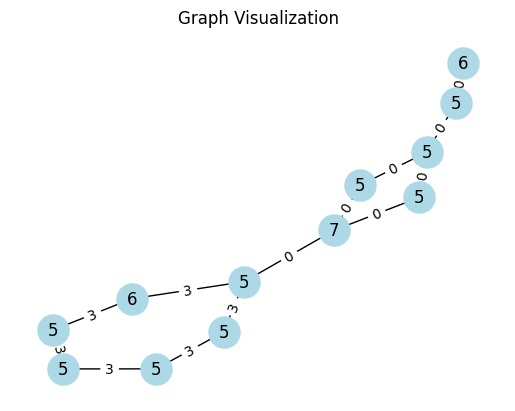

In [215]:
from src.utils.my_utiles import plot_graph
plot_graph(graph_x, graph_edge_index, graph_edge_attr)

In [216]:
smiles = graph2smiles(graph_edge_index, graph_edge_attr, graph_x)
print("SMILES:", smiles)

[16:38:09] Explicit valence for atom # 3 O, 3, is greater than permitted


AtomValenceException: Explicit valence for atom # 3 O, 3, is greater than permitted

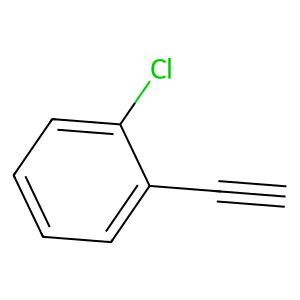

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert the SMILES string to a molecule object
molecule = Chem.MolFromSmiles(smiles)

# Draw the molecule
Draw.MolToImage(molecule)
